<a href="https://colab.research.google.com/github/sadrireza/Neural-Networks/blob/main/Deep_Learning_on_Small_Image_Datasets_Using_Pretrained_Model_(Using_transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision (Men-Women Detection)
##Using Transfer learning

In [3]:
%%capture
'''
A Pre-trained model is a model that was previously trained on a
large dataset, typically on a large-scale image-classification task.
So its features can prove useful for many different computer vision problems,
even though these new problems may involve completely different classes.
For instance the pretrained model is trained on Imagenet (classes are animals)
and then repurpose it for furniture
we have different options. the first option is Keras Applications
'''

In [15]:
#using os to count no. of files in each folder
import os

#to organize dataset directories
import shutil
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

## 1. Dataset Preparation

### 1.1 Download Dataset from Koggle

In [4]:
'''since we need to upload kaggle.json file to be able to use kaggle datasets,
we use this method to upload a file from our system.
 the _ is used for temporary variables in python
 and we use it not to show the content of file here for security reasons'''
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
#A linux code to transfer the file because colab base is linux
!mkdir ~/.kaggle #make the directory in linux
!cp kaggle.json ~/.kaggle #copy in linux
!chmod 600 ~/.kaggle/kaggle.json #for security reasons,restricting access to file to the owner

#in windows we have to save kaggle.jason in this path:
#C:\Users\username\.kaggle
#We have to download kaggle.json from our personal area in kaggle website
#in the API section

In [6]:
#downloading dataset from kaggle website (!kaggle datasets download -d username/dataset name)
!kaggle datasets download -d saadpd/menwomen-classification

Dataset URL: https://www.kaggle.com/datasets/saadpd/menwomen-classification
License(s): copyright-authors
100% 804M/806M [00:08<00:00, 97.9MB/s]
100% 806M/806M [00:08<00:00, 94.4MB/s]


In [7]:
#unzipping dataset(-qq for not showing extracted files)
!unzip -qq menwomen-classification.zip

### 1.2 Dataset Evaluation

In [8]:
#to correct numerous places at the same time, use Alt
num_men_train = len(os.listdir('traindata/traindata/men'))
num_women_train = len(os.listdir('traindata/traindata/women'))
num_men_test = len(os.listdir('testdata/testdata/men'))
num_women_test = len(os.listdir('testdata/testdata/women'))

print (f'Train: Men: {num_men_train} & Women: {num_women_train}')
print (f'Test: Men: {num_men_test} & Women: {num_women_test}')

Train: Men: 1000 & Women: 1912
Test: Men: 418 & Women: 915


###1.3 Prepare Data Directories

In [9]:
'''
Dataset is not suitable rightnow
Dataset should be such that each folder contains only images of one class only
we can do this either with coding or manually in our system
'''

new_base_dir = pathlib.Path('men_vs_women_small') #the base directory is made

'''make_subset gets two indexes to know from which image begins
 and to which one ends in each folder'''

def make_subset(base_dir, subset_name, start_index, end_index):
    for category in ('men', 'women'):
        dir = new_base_dir / subset_name / category
        if not os.path.exists(dir):
          os.makedirs(dir) #All above folders and subfolder are made

        '''
        above we want to make a directory. the address of directory
        is like what is equal to dir. so the main directory is called new_base_dir
        and the subfolder is a name which we give in later (subset_name)
        and then we have two categories men and women
        '''

        #getting all files from the source directory by listdir
        files = os.listdir(os.path.join(base_dir, category))

        #getting names of those images we want from start index to end index
        fnames = [files[i] for i in range(start_index, end_index)]

        #copying those images to the destination directory
        for fname in fnames:
          shutil.copyfile(src=os.path.join(base_dir, category, fname),
                      dst=os.path.join(dir,fname))

          '''
To turn image files into batches of preprocessed tensors in general,
Keras features the utility function:
image_dataset_from_directory()
1-list the subdirectories of directory
2-assume each one contains one class
3-index the image files in each subd.
4-create and return a tf.data.Dataset object
this object configured to read files,
shuffle them, decode them to tensors, resize them to
a shared size,pack them into batches
'''

In [10]:
#now we use make_subset
make_subset('traindata/traindata', 'validation', start_index=0, end_index=200)
make_subset('traindata/traindata', 'train', start_index=200, end_index=999)
make_subset('testdata/testdata', 'test', start_index=0, end_index=400)

###1.4 Load Dataset

In [11]:
print ('Train loader:') #to determine which report is shown
train_dataset = image_dataset_from_directory(
    'men_vs_women_small/train',
    image_size = (180,180),
    batch_size=32,
    label_mode = 'binary' #because we have only two classes
)
print ('Validation loader:') #to determine which report is shown
validation_dataset = image_dataset_from_directory(
    'men_vs_women_small/validation',
    image_size = (180,180),
    batch_size=32,
    label_mode = 'binary' #because we have only two classes
)

print ('Test loader:') #to determine which report is shown
test_dataset = image_dataset_from_directory(
    'men_vs_women_small/test',
    image_size = (180,180),
    batch_size=32,
    label_mode = 'binary' #because we have only two classes
)

Train loader:
Found 1598 files belonging to 2 classes.
Validation loader:
Found 400 files belonging to 2 classes.
Test loader:
Found 800 files belonging to 2 classes.


data batch shape: (32, 180, 180, 3)
label batch shape: (32, 1)


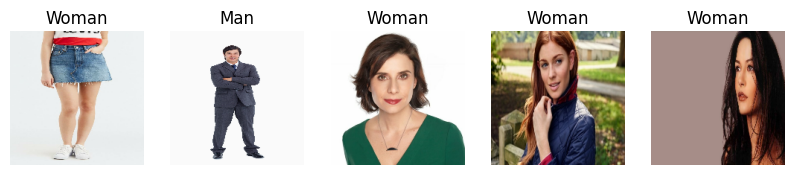

In [12]:
#showing 5 samples
for data_batch, label_batch in train_dataset:
  print('data batch shape:', data_batch.shape)
  print('label batch shape:', label_batch.shape)

  #Show five random examples of the loaded batch
  fig, axes = plt.subplots(1, 5, figsize = (10,3))
  for i, ax in enumerate(axes):
    ax.imshow(data_batch[i].numpy().astype('uint8'))
    ax.set_axis_off()
    ax.set_title('Man' if label_batch[i].numpy()==0 else 'Woman')
  break
plt.show()

## 2. Building  the Model

In [14]:
#Loading our pre_trained model
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet', #bring in imagenet weights
    include_top=False, #no need to last dense layer
    input_shape=(180,180,3))

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

###2.1 Building

In [17]:
#Feature Extraction Without Data Augmentation
def get_features_and_labels(dataset):
  #initializes empty lists to store features and labels
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    #the model here isnot being trained. just used to get feature representations of the input image (extracting features)
    features = conv_base.predict(preprocessed_images, verbose=0)
    #add extracted features and labels
    all_features.append(features)
    all_labels.append(labels)
  #concatenate all feature arrays, creating a single numpy array
  return np.concatenate(all_features), np.concatenate(all_labels)

#calling functions for different datasets
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

In [18]:
train_features.shape
#(samples, 5, 5, 512)

(1598, 5, 5, 512)

In [21]:
test_features.shape

(800, 5, 5, 512)

###2.1.1. Defining and Training the Densely Connected Classifier

In [23]:
#We define our densely connected classifier
inputs = keras. Input(shape=(5, 5, 512))
#x = layers.Flatten()(inputs) #Using flatten layer before passing features to dense layer
#instead of flatten layer, we use global average pooling because it creates less parameters which is better
#for each feature, a pooling is done
x = layers.GlobalAveragePooling2D()(inputs)
x = layers.Dense(256)(x)
#a dropout layer for regularization
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,585 (514.00 KB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 0 (0.00 B)

###2.2 Compilation

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

2.3 Fitting the Model



In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='covnet_from_scratch.keras',
        save_best_only=True,
        monitor='val_loss'
        )
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

#running epochs with this model is so fast
#because we used pre-trained model

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6583 - loss: 4.1485 - val_accuracy: 0.6925 - val_loss: 3.1962
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8386 - loss: 1.4097 - val_accuracy: 0.8375 - val_loss: 1.2158
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8616 - loss: 1.1209 - val_accuracy: 0.8475 - val_loss: 1.0086
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8582 - loss: 1.0482 - val_accuracy: 0.8150 - val_loss: 1.4071
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8736 - loss: 0.9124 - val_accuracy: 0.8625 - val_loss: 0.8751
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8769 - loss: 0.7790 - val_accuracy: 0.8200 - val_loss: 1.2748
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8990 - loss: 0.5473 - val_accuracy: 0.8375 - val_loss: 1.0703
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8708 - loss: 0.8708 - val_accuracy: 0.8575 - val_lo

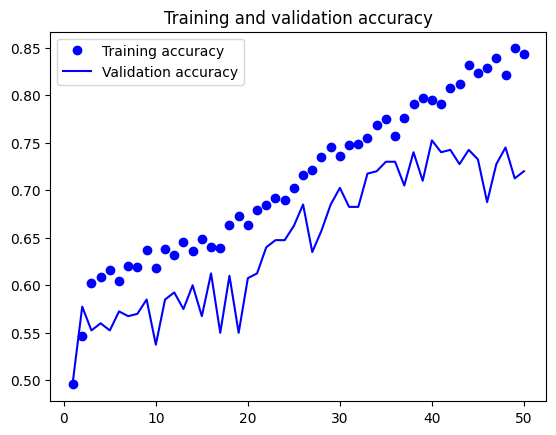

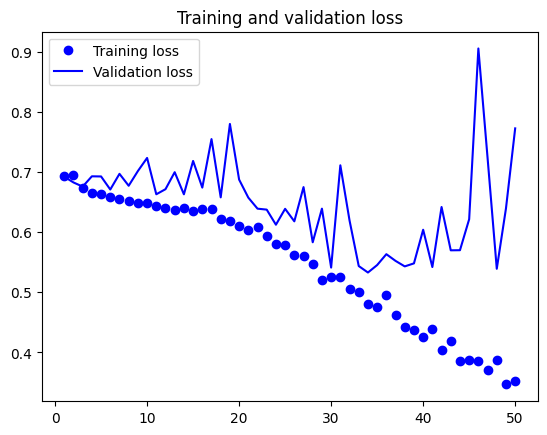

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#As we see here, the overfitting is less than the case which we did not have augmentation

###2.3 Evaluation

In [30]:
import os
print(os.listdir("."))

['.config', 'covnet_from_scratch.keras', 'men_vs_women_small', 'testdata', 'kaggle.json', 'traindata', 'menwomen-classification.zip', 'sample_data']


In [31]:
test_model = keras.models.load_model("/content/covnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8940 - loss: 0.3963
Test accuracy: 0.904


In [32]:
%%capture
'''
in comparison to data augmentation method (computer vision file):
running time is shorter
accuracy is higher
loss is lower
but overfitting is worse
'''